In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
import os
import sklearn 
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df_narr = pd.read_csv('/content/drive/MyDrive/Classes/2 Practicum/[For Classmates 3-Feb-2021] cfpb_cleaned/data_files/STM/stm_labeled_data')

In [ ]:
df_narr.shape

(657663, 35)

In [ ]:
df_narr.head()

,Unnamed: 0,X,Date.received,Product,Sub.product,Issue,Sub.issue,Consumer.complaint.narrative,Company.public.response,Company,State,ZIP.code,Tags,Consumer.consent.provided.,Submitted.via,Date.sent.to.company,Company.response.to.consumer,Timely.response.,Consumer.disputed.,Complaint.ID,Complaint.length,Credit Report Inaccuracies,Unauthorised Accounts and Credit Inquiries,"Debt: Financing Issues, Wage Garnishment",Identity Theft,Car Dealerships & Automobiles,Loan Mismanagement & Misinformation,Lawsuits,Disputing Late Payments,"Response Time, Disputing Responses/Follow-up Actions",Credit Card Promotions/Offers,Bank Account Mismanagement: Deposits and Checks,"Harassment, Robo-calls",Debt: Disputing Validity,???
0,1,0,2019-09-24,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,transworld system inc try collect debt mine ow...,NaN,TRANSWORLD SYSTEMS INC,FL,335XX,NaN,Consent provided,Web,2019-09-24,Closed with explanation,Yes,NaN,3384392,18,0.096474,0.078254,0.072441,0.026175,0.011058,0.004998,0.018770,0.022178,0.055505,0.006972,0.002848,0.043599,0.553171,0.007557
1,2,1,2019-11-08,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,past week receive excessive amount telephone c...,NaN,"Diversified Consultants, Inc.",NC,275XX,NaN,Consent provided,Web,2019-11-08,Closed with explanation,Yes,NaN,3433198,78,0.019815,0.019204,0.158436,0.010826,0.019941,0.021786,0.025619,0.055491,0.034353,0.028507,0.024002,0.448207,0.127478,0.006335
2,3,2,2019-09-15,Debt collection,Other debt,Attempts to collect debt not owed,Debt was result of identity theft,pioneer commit several federal violation priva...,NaN,Pioneer Capital Solutions Inc,CA,925XX,NaN,Consent provided,Web,2019-09-15,Closed with explanation,Yes,NaN,3374555,152,0.011814,0.021889,0.026804,0.040312,0.005265,0.005686,0.490380,0.005838,0.025370,0.011836,0.005633,0.015032,0.325756,0.008387
3,4,3,2019-07-26,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,previously request experian send copy verifiab...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,CA,914XX,NaN,Consent provided,Web,2019-07-26,Closed with explanation,Yes,NaN,3319331,171,0.134283,0.070862,0.003823,0.011455,0.004021,0.001923,0.008228,0.018626,0.709530,0.004819,0.002392,0.014312,0.011864,0.003862
4,5,4,2019-07-08,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,hello complaint three credit report company tr...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",NY,109XX,NaN,Consent provided,Web,2019-07-08,Closed with explanation,Yes,NaN,3299394,428,0.145764,0.159703,0.045046,0.068835,0.010620,0.002595,0.015779,0.010961,0.332880,0.015450,0.036293,0.119049,0.022445,0.014582


In [ ]:
df_narr.columns

Index(['Unnamed: 0', 'X', 'Date.received', 'Product', 'Sub.product', 'Issue',
       'Sub.issue', 'Consumer.complaint.narrative', 'Company.public.response',
       'Company', 'State', 'ZIP.code', 'Tags', 'Consumer.consent.provided.',
       'Submitted.via', 'Date.sent.to.company', 'Company.response.to.consumer',
       'Timely.response.', 'Consumer.disputed.', 'Complaint.ID',
       'Complaint.length', 'Credit Report Inaccuracies',
       'Unauthorised Accounts and Credit Inquiries',
       'Debt: Financing Issues, Wage Garnishment', 'Identity Theft',
       'Car Dealerships & Automobiles', 'Loan Mismanagement & Misinformation',
       'Lawsuits', 'Disputing Late Payments',
       'Response Time, Disputing Responses/Follow-up Actions',
       'Credit Card Promotions/Offers',
       'Bank Account Mismanagement: Deposits and Checks',
       'Harassment, Robo-calls', 'Debt: Disputing Validity', '???'],
      dtype='object')

# Topic Prevalance over time

## STM Model (as of 10-Feb-2021)

### Explaining the Topic Weight

In [ ]:
df_narr.columns[::-1][0:14]

#topics

Index(['???', 'Debt: Disputing Validity', 'Harassment, Robo-calls',
       'Bank Account Mismanagement: Deposits and Checks',
       'Credit Card Promotions/Offers',
       'Response Time, Disputing Responses/Follow-up Actions',
       'Disputing Late Payments', 'Lawsuits',
       'Loan Mismanagement & Misinformation', 'Car Dealerships & Automobiles',
       'Identity Theft', 'Debt: Financing Issues, Wage Garnishment',
       'Unauthorised Accounts and Credit Inquiries',
       'Credit Report Inaccuracies'],
      dtype='object')

In [ ]:
df_probs = df_narr.iloc[:, ::-1].iloc[:, 0:14]

df_probs.head()

,???,Debt: Disputing Validity,"Harassment, Robo-calls",Bank Account Mismanagement: Deposits and Checks,Credit Card Promotions/Offers,"Response Time, Disputing Responses/Follow-up Actions",Disputing Late Payments,Lawsuits,Loan Mismanagement & Misinformation,Car Dealerships & Automobiles,Identity Theft,"Debt: Financing Issues, Wage Garnishment",Unauthorised Accounts and Credit Inquiries,Credit Report Inaccuracies
0,0.007557,0.553171,0.043599,0.002848,0.006972,0.055505,0.022178,0.018770,0.004998,0.011058,0.026175,0.072441,0.078254,0.096474
1,0.006335,0.127478,0.448207,0.024002,0.028507,0.034353,0.055491,0.025619,0.021786,0.019941,0.010826,0.158436,0.019204,0.019815
2,0.008387,0.325756,0.015032,0.005633,0.011836,0.025370,0.005838,0.490380,0.005686,0.005265,0.040312,0.026804,0.021889,0.011814
3,0.003862,0.011864,0.014312,0.002392,0.004819,0.709530,0.018626,0.008228,0.001923,0.004021,0.011455,0.003823,0.070862,0.134283
4,0.014582,0.022445,0.119049,0.036293,0.015450,0.332880,0.010961,0.015779,0.002595,0.010620,0.068835,0.045046,0.159703,0.145764


**Output from STM**: 
- We get 14 Probabilities per Complaint, persuant to each Topic.
- We assign each Complaint to a Topic given their highest probability out of the 14, `max_prob`. 

This is not an even distribution: 

```
8     108370
11     69219
13     68308
12     64378
4      58759
1      47146
7      45332
6      43343
5      42944
3      41239
2      24549
10     24018
9      18715
0       1343
Name: Topic_Num, dtype: int64

```
- We also use the numerical value of `max_prob` as an indication of topic importance, since it means that **more words in the associated complaints are related to the given complaint**. We call this **Topic Weight**. 


### Preprocessing and Descriptives

In [ ]:
top_topic = df_probs.idxmax(axis=1)

In [ ]:
top_prob = df_probs.max(axis=1)

In [ ]:
date_rec = df_narr['Date.received']

date_rec

0         2019-09-24
1         2019-11-08
2         2019-09-15
3         2019-07-26
4         2019-07-08
             ...    
657658    2016-07-11
657659    2017-01-24
657660    2015-03-26
657661    2015-12-12
657662    2016-08-09
Name: Date.received, Length: 657663, dtype: object

In [ ]:
df_topic = pd.concat([top_topic, top_prob, date_rec], axis = 1)

df_topic.columns =['Topic', 'max_prob', 'date_rec'] 

In [ ]:
df_topic['date_rec'] = pd.to_datetime(df_topic['date_rec'])

In [ ]:
df_topic['year'] = pd.DatetimeIndex(df_topic['date_rec']).year
df_topic['month'] = pd.DatetimeIndex(df_topic['date_rec']).month

In [ ]:
df_topic 

,Topic,max_prob,date_rec,year,month
0,Debt: Disputing Validity,0.553171,2019-09-24,2019,9
1,"Harassment, Robo-calls",0.448207,2019-11-08,2019,11
2,Lawsuits,0.490380,2019-09-15,2019,9
3,"Response Time, Disputing Responses/Follow-up A...",0.709530,2019-07-26,2019,7
4,"Response Time, Disputing Responses/Follow-up A...",0.332880,2019-07-08,2019,7
...,...,...,...,...,...
657658,Disputing Late Payments,0.326516,2016-07-11,2016,7
657659,"Harassment, Robo-calls",0.452022,2017-01-24,2017,1
657660,Loan Mismanagement & Misinformation,0.362975,2015-03-26,2015,3
657661,Loan Mismanagement & Misinformation,0.392683,2015-12-12,2015,12


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_topic['Topic_Num'] = le.fit_transform(df_topic['Topic'])

In [ ]:
list(le.classes_)

['???',
 'Bank Account Mismanagement: Deposits and Checks',
 'Car Dealerships & Automobiles',
 'Credit Card Promotions/Offers',
 'Credit Report Inaccuracies',
 'Debt: Disputing Validity',
 'Debt: Financing Issues, Wage Garnishment',
 'Disputing Late Payments',
 'Harassment, Robo-calls',
 'Identity Theft',
 'Lawsuits',
 'Loan Mismanagement & Misinformation',
 'Response Time, Disputing Responses/Follow-up Actions',
 'Unauthorised Accounts and Credit Inquiries']

In [ ]:
df_topic.head()

,Topic,max_prob,date_rec,year,month,Topic_Num
0,Debt: Disputing Validity,0.553171,2019-09-24,2019,9,5
1,"Harassment, Robo-calls",0.448207,2019-11-08,2019,11,8
2,Lawsuits,0.490380,2019-09-15,2019,9,10
3,"Response Time, Disputing Responses/Follow-up A...",0.709530,2019-07-26,2019,7,12
4,"Response Time, Disputing Responses/Follow-up A...",0.332880,2019-07-08,2019,7,12


In [ ]:
df_topic['Topic_Num'].unique()

array([ 5,  8, 10, 12,  4,  7,  1, 13, 11,  9,  2,  0,  3,  6])

In [ ]:
df_topic['Topic_Num'].value_counts()

8     108370
11     69219
13     68308
12     64378
4      58759
1      47146
7      45332
6      43343
5      42944
3      41239
2      24549
10     24018
9      18715
0       1343
Name: Topic_Num, dtype: int64

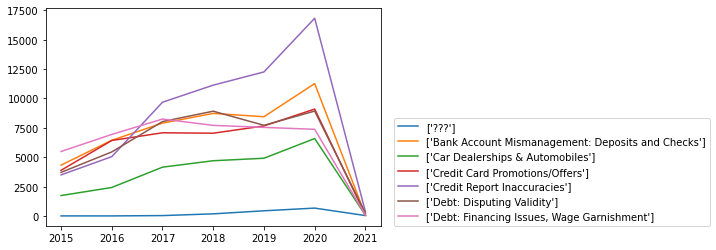

In [ ]:
for x in range(0, 7): 
  plt.plot(df_topic[df_topic['Topic_Num'] == x]['Topic'].groupby(df_topic['year']).agg('count'), label = df_topic[df_topic['Topic_Num'] == x]['Topic'].unique())
  plt.legend(loc=(1.04,0))

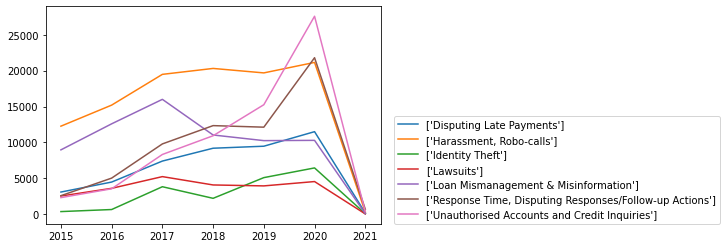

In [ ]:
for x in range(7, 14): 
  plt.plot(df_topic[df_topic['Topic_Num'] == x]['Topic'].groupby(df_topic['year']).agg('count'), label = df_topic[df_topic['Topic_Num'] == x]['Topic'].unique())
  plt.legend(loc=(1.04,0))

In [ ]:
#Summary Stats of Topic Weight

print("Max: {}".format(df_topic['max_prob'].max()))
print("Min: {}".format(df_topic['max_prob'].min()))
print("Average: {}".format(df_topic['max_prob'].mean()))
print("Median: {}".format(df_topic['max_prob'].median()))
print("Most frequent value: {}".format(df_topic['max_prob'].round(3).value_counts().idxmax()))

Max: 0.984079328938175
Min: 0.111191125577847
Average: 0.3721385006113288
Median: 0.348098213939442
Most frequent value: 0.282


Text(0.5, 0.98, 'Scatterplot of Topic Weights, Split by Topic; All Weights.')

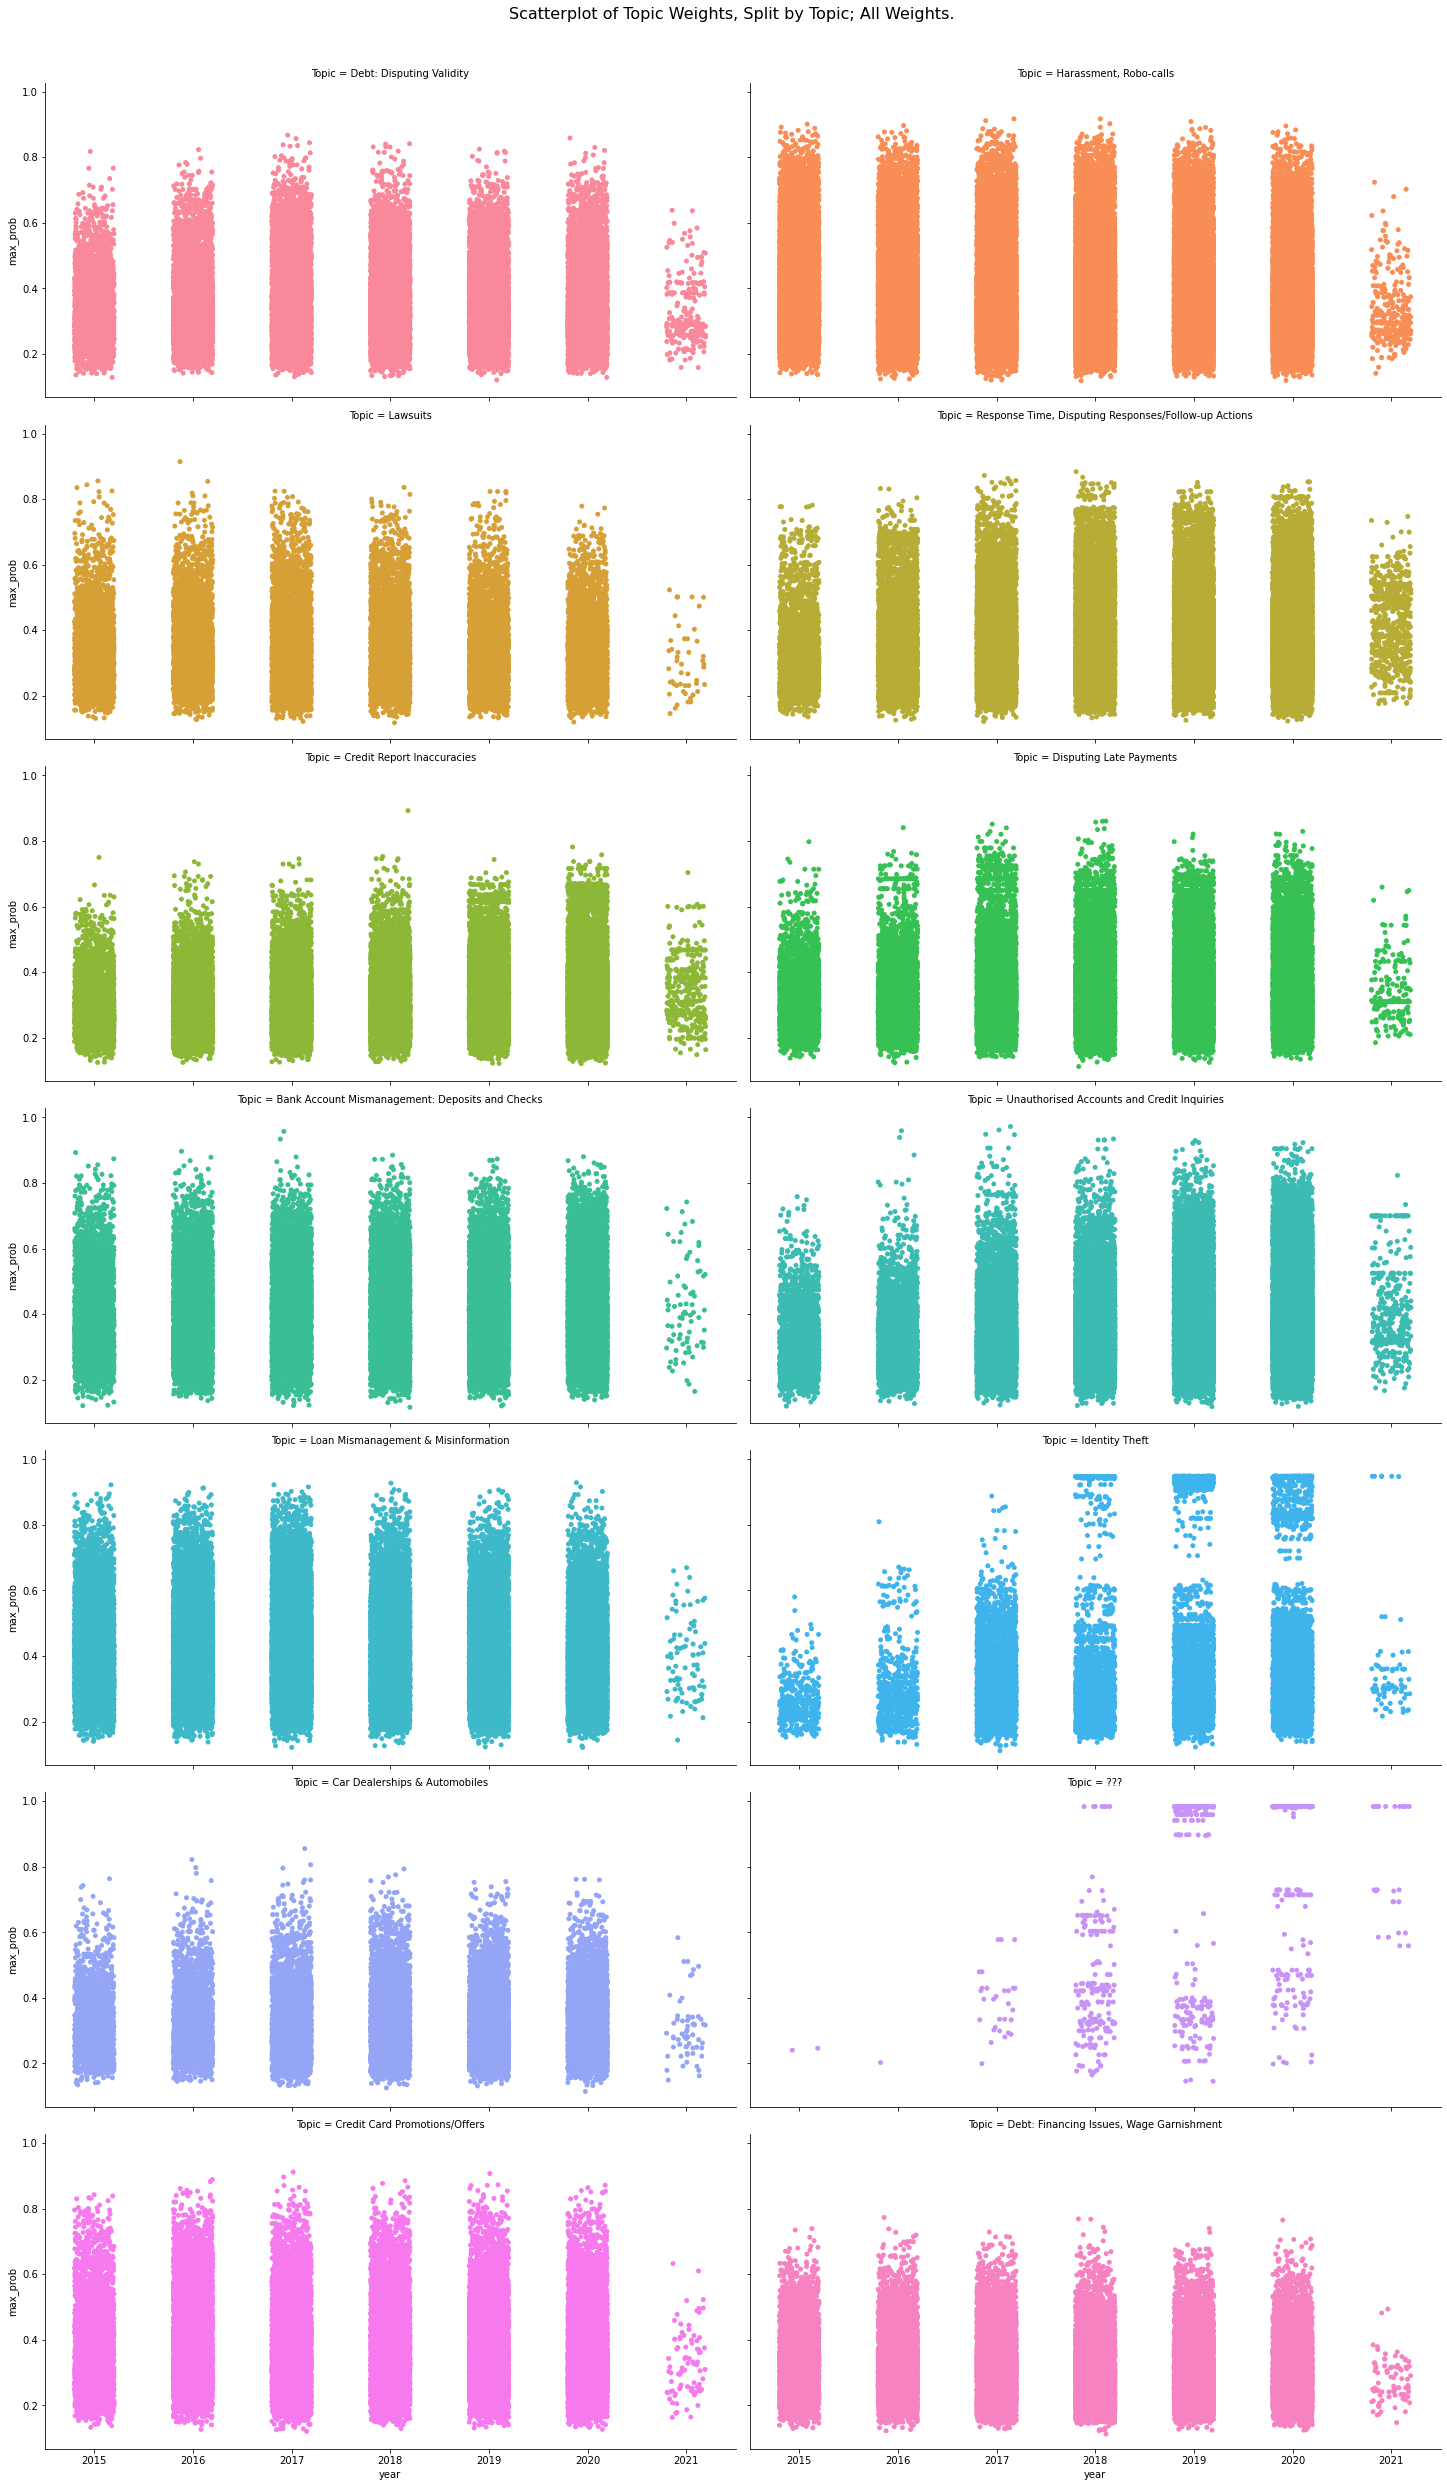

In [ ]:
p = sns.catplot(x="year", y='max_prob', hue="Topic", col = "Topic", col_wrap = 2,
                   kind='strip', aspect=2, jitter=0.2, data=df_topic)
p.fig.subplots_adjust(top=0.95)
p.fig.suptitle("Scatterplot of Topic Weights, Split by Topic; All Weights.", fontsize=16)

Resources referenced for this segment: 
- https://jeriwieringa.com/2017/06/21/Calculating-and-Visualizing-Topic-Significance-over-Time-Part-1/#topic=16&lambda=0.06&term= (Four Part Series, with four different approaches)

### Smoothing or regression analysis

Rolling Means of the Topic Weights across Months, for one topic, per year

In [ ]:
def create_plotpoint(df, y_value, hue=None, col=None, wrap=None, size=6, aspect=2, title=""):
    p = sns.factorplot(x="month", y=y_value, kind='point', 
                        hue=hue, 
                       col=col, col_wrap=wrap, 
                       size=size, aspect=aspect, data=df)
    p.fig.subplots_adjust(top=0.9)
    p.fig.suptitle(title, fontsize=16)
    return p

In [ ]:
t4 = df_topic.query(f'Topic_Num == 4 & year == 2015')

t4

,Topic,max_prob,date_rec,year,month,Topic_Num
13809,Credit Report Inaccuracies,0.272211,2015-12-25,2015,12,4
16610,Credit Report Inaccuracies,0.344094,2015-11-10,2015,11,4
25456,Credit Report Inaccuracies,0.220870,2015-10-17,2015,10,4
167952,Credit Report Inaccuracies,0.241984,2015-09-28,2015,9,4
170890,Credit Report Inaccuracies,0.194763,2015-08-18,2015,8,4
...,...,...,...,...,...,...
603473,Credit Report Inaccuracies,0.423684,2015-03-20,2015,3,4
603509,Credit Report Inaccuracies,0.226784,2015-11-01,2015,11,4
604220,Credit Report Inaccuracies,0.305525,2015-07-01,2015,7,4
604421,Credit Report Inaccuracies,0.330106,2015-07-21,2015,7,4


In [ ]:
t4grouped = t4.groupby('month')['max_prob'].mean()

t4grouped

month
3     0.307822
4     0.294955
5     0.305284
6     0.300994
7     0.296105
8     0.295534
9     0.296478
10    0.300679
11    0.305692
12    0.306937
Name: max_prob, dtype: float64

In [ ]:
t4rolling = t4grouped.rolling(2).mean().reset_index()
t4rolling.columns = ['month', 'rolling_mean']

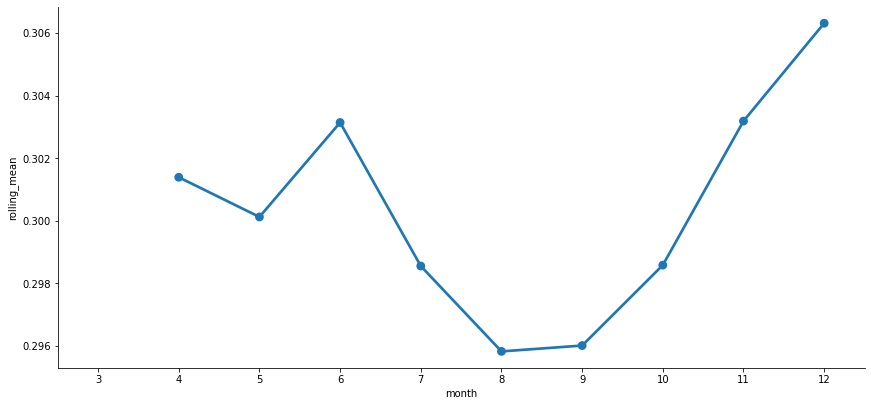

In [ ]:
create_plotpoint(t4rolling, 'rolling_mean')

In [ ]:
def rolling_mean_topic_weight(Topic_Num, year): 
    
    def create_plotpoint(df, y_value, hue=None, col=None, wrap=None, size=6, aspect=2, title=""):
        p = sns.factorplot(x="month", y=y_value, kind='point', 
                        hue=hue, 
                       col=col, col_wrap=wrap, 
                       size=size, aspect=aspect, data=df)
        p.fig.subplots_adjust(top=0.9)
        p.fig.suptitle(title, fontsize=16)
        return p

    t = df_topic.query(f'Topic_Num == {Topic_Num} & year == {year}')
    tgrouped = t.groupby('month')['max_prob'].mean()
    t_rolling = tgrouped.rolling(2).mean().reset_index()
    t_rolling.columns = ['month', 'rolling_mean']
    create_plotpoint(t_rolling, 'rolling_mean')

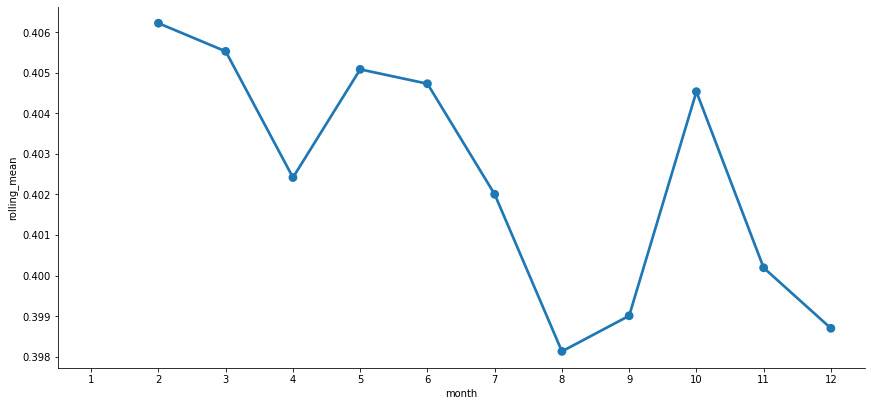

In [ ]:
rolling_mean_topic_weight(1, 2019) #example

### Average Topic Weight Per Year

In [ ]:
total_docs = df_topic.year.value_counts()

In [ ]:
total_docs = pd.DataFrame(total_docs).reset_index()
total_docs.columns = ['year', 'total_docs']
total_docs

,year,total_docs
0,2020,164002
1,2019,124764
2,2018,118475
3,2017,115167
4,2016,77819
5,2015,54748
6,2021,2688


Data is definitely more skewed recent years, sans 2021.

In [ ]:
df_avg = df_topic.groupby(['year', 'Topic']).agg({'max_prob': 'sum'}).reset_index()
df_avg.head()

#summing max_probs for topic, per year

,year,Topic,max_prob
0,2015,???,0.487094
1,2015,Bank Account Mismanagement: Deposits and Checks,1718.858922
2,2015,Car Dealerships & Automobiles,563.503202
3,2015,Credit Card Promotions/Offers,1474.632504
4,2015,Credit Report Inaccuracies,1048.435568


In [ ]:
df_avg = df_avg.merge(total_docs, on="year", how="left")
print(df_avg.head())
print(df_avg.tail())
df_avg.shape

   year  ... total_docs
0  2015  ...      54748
1  2015  ...      54748
2  2015  ...      54748
3  2015  ...      54748
4  2015  ...      54748

[5 rows x 4 columns]
    year  ... total_docs
93  2021  ...       2688
94  2021  ...       2688
95  2021  ...       2688
96  2021  ...       2688
97  2021  ...       2688

[5 rows x 4 columns]


(98, 4)

In [ ]:
df_avg['average_weight'] = df_avg['max_prob'] / df_avg['total_docs'] #total_documents within the year

In [ ]:
df_avg.drop('max_prob', axis = 1, inplace = True)
df_avg

,year,Topic,total_docs,average_weight
0,2015,???,54748,0.000009
1,2015,Bank Account Mismanagement: Deposits and Checks,54748,0.031396
2,2015,Car Dealerships & Automobiles,54748,0.010293
3,2015,Credit Card Promotions/Offers,54748,0.026935
4,2015,Credit Report Inaccuracies,54748,0.019150
...,...,...,...,...
93,2021,Identity Theft,2688,0.010562
94,2021,Lawsuits,2688,0.005392
95,2021,Loan Mismanagement & Misinformation,2688,0.012387
96,2021,"Response Time, Disputing Responses/Follow-up A...",2688,0.110384


In [ ]:
def create_bar(df, y_value, hue=None, col=None, wrap=None, size=5, aspect=1.5, title=""):
    p = sns.factorplot(x="year", y=y_value, kind='bar', hue=hue, 
                       col=col, col_wrap=wrap, size=size, aspect=aspect, data=df)
    p.fig.subplots_adjust(top=0.9)
    p.fig.suptitle(title, fontsize=16)
    return p

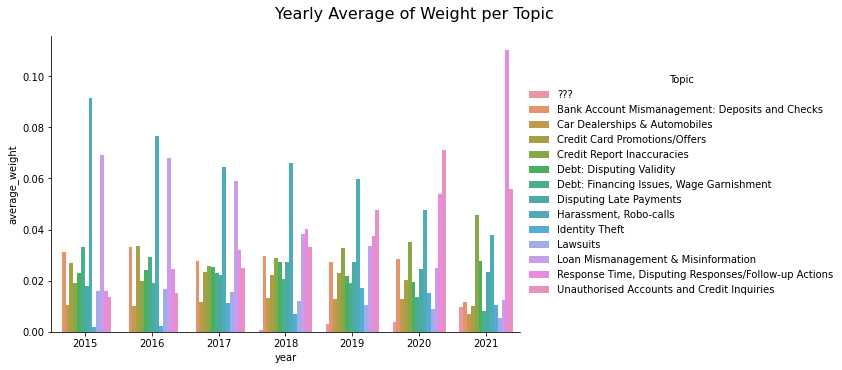

In [ ]:
create_bar(df_avg, 'average_weight', hue="Topic",
          title="Yearly Average of Weight per Topic")

In [ ]:
def create_pointplot(df, y_value, hue=None, col=None, wrap=None, size=5, aspect=1.5, title=""):
    p = sns.factorplot(x="year", y=y_value, kind='point', hue=hue, 
                       col=col, col_wrap=wrap, size=size, aspect=aspect, data=df)
    p.fig.subplots_adjust(top=0.9)
    p.fig.suptitle(title, fontsize=16)
    return p

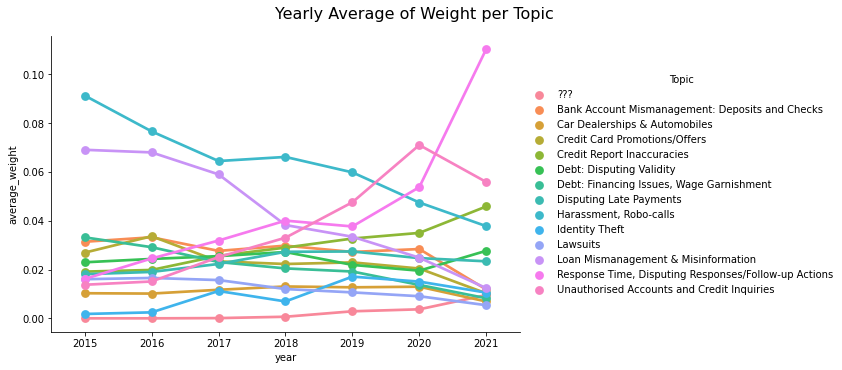

In [ ]:
create_pointplot(df_avg, 'average_weight', hue="Topic",
                title="Yearly Average of Weight per Topic")